Get the dataset from Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Found GPU at: /device:GPU:0
Fri Jul 15 07:54:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    36W / 250W |    389MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

Load dataset and split between hands and no hands:

In [ ]:
import os
import numpy as np
from PIL import Image
from os import listdir
from xml.etree import ElementTree
import cv2
from google.colab.patches import cv2_imshow

#import all images
dataset_dir = '/content/drive/My Drive/Colab Notebooks'
images_dir = dataset_dir + '/images/'
boxes_dir = dataset_dir + '/boxes/'

os.mkdir('/content/drive/My Drive/Colab Notebooks/dataset')
#os.mkdir('/content/drive/My Drive/Colab Notebooks/dataset/hand')
#os.mkdir('/content/drive/My Drive/Colab Notebooks/dataset/no_hand')

i = 0
for filename in listdir(images_dir):
  i = i + 1
  # extract image id
  if(i>=4169):
    image_id = filename[:-4]
    image = cv2.imread(images_dir + filename)
    tree = ElementTree.parse(boxes_dir + image_id + '.xml')
    # get the root of the document
    root = tree.getroot()
    n = 0
    matrix = np.zeros((image.shape[0], image.shape[1])) 
    for box in root.findall('.//bndbox'):
      n = n + 1
      xmin = int(box.find('xmin').text)
      ymin = int(box.find('ymin').text)
      xmax = int(box.find('xmax').text)
      ymax = int(box.find('ymax').text)
      matrix[ymin: ymax, xmin: xmax] = 1
      positive = image[ymin:ymax, xmin:xmax]
      #print(str(image.shape[0]) + ', ' + str(image.shape[1]))
      #print(str(xmin) + ', ' + str(xmax) + ', ' + str(ymin) + ', ' + str(ymax)  + '\n')
      positive = cv2.resize(positive, (448,448), cv2.INTER_CUBIC)
      cv2.imwrite('/content/drive/My Drive/Colab Notebooks/dataset/hand/' 
                  + str(image_id) + '_' + str(n) + '.jpg', positive)
    j=0
    for row in range(0,image.shape[0],224):
        for col in range(0,image.shape[1],224):                   
          if(matrix[row:row+224, col:col+224].sum() == 0):
            negative = image[row : row + 224, col : col + 224]
            negative = cv2.resize(negative,(448,448), cv2.INTER_CUBIC)
            #cv2_imshow(negative)
            cv2.imwrite('/content/drive/My Drive/Colab Notebooks/dataset/no_hand/' 
                        + str(image_id) + '_' + str(j) + '.jpg', negative)
            j=j+1
  print('processed images: ' + str(i))

#split hand and no hand dataset into train-validation-test

FileExistsError: ignored

Split into train-validation-test:

In [ ]:
data_dir = '/content/drive/My Drive/Colab Notebooks/dataset'
dataset_dir = '/content/drive/My Drive/Colab Notebooks'
images_dir = dataset_dir + '/images/'
boxes_dir = dataset_dir + '/boxes/'

#os.mkdir(data_dir + '/train/')
#os.mkdir(data_dir + '/validation/')
#os.mkdir(data_dir + '/test/')
#os.mkdir(data_dir + '/train/hand')
#os.mkdir(data_dir + '/train/no_hand')
#os.mkdir(data_dir + '/validation/hand')
#os.mkdir(data_dir + '/validation/no_hand')
#os.mkdir(data_dir + '/test/hand')
#os.mkdir(data_dir + '/test/no_hand')

#process hand samples
i = -1
is_test = True
for filename in listdir('/content/drive/My Drive/Colab Notebooks/dataset/hand'):
  i = i + 1
  # extract image id
  image_id = filename[:-4]
  image = cv2.imread('/content/drive/My Drive/Colab Notebooks/dataset/hand/' + filename)
  if i%4 == 0:
    if is_test:
      cv2.imwrite('/content/drive/My Drive/Colab Notebooks/dataset/test/hand/' 
                + str(image_id) + '.jpg', image)
      is_test = False
    else:
      cv2.imwrite('/content/drive/My Drive/Colab Notebooks/dataset/validation/hand/' 
                + str(image_id) + '.jpg', image)
      is_test = True
  else:
      cv2.imwrite('/content/drive/My Drive/Colab Notebooks/dataset/train/hand/' 
                + str(image_id) + '.jpg', image)
  print('processed hand images: ' + str(i))

#process no_hand samples
i = -1
is_test = True
for filename in listdir('/content/drive/My Drive/Colab Notebooks/dataset/no_hand'):
  i = i + 1
  # extract image id
  if(i>53400):
    image_id = filename[:-4]
    image = cv2.imread('/content/drive/My Drive/Colab Notebooks/dataset/no_hand/' + filename)
    if i%4 == 0:
      if is_test:
        cv2.imwrite('/content/drive/My Drive/Colab Notebooks/dataset/test/no_hand/' 
                  + str(image_id) + '.jpg', image)
        is_test = False
      else:
        cv2.imwrite('/content/drive/My Drive/Colab Notebooks/dataset/validation/no_hand/' 
                  + str(image_id) + '.jpg', image)
        is_test = True
    else:
        cv2.imwrite('/content/drive/My Drive/Colab Notebooks/dataset/train/no_hand/' 
                  + str(image_id) + '.jpg', image)
  print('processed no_hand images: ' + str(i))

Output streaming troncato alle ultime 5000 righe.
processed no_hand images: 48409
processed no_hand images: 48410
processed no_hand images: 48411
processed no_hand images: 48412
processed no_hand images: 48413
processed no_hand images: 48414
processed no_hand images: 48415
processed no_hand images: 48416
processed no_hand images: 48417
processed no_hand images: 48418
processed no_hand images: 48419
processed no_hand images: 48420
processed no_hand images: 48421
processed no_hand images: 48422
processed no_hand images: 48423
processed no_hand images: 48424
processed no_hand images: 48425
processed no_hand images: 48426
processed no_hand images: 48427
processed no_hand images: 48428
processed no_hand images: 48429
processed no_hand images: 48430
processed no_hand images: 48431
processed no_hand images: 48432
processed no_hand images: 48433
processed no_hand images: 48434
processed no_hand images: 48435
processed no_hand images: 48436
processed no_hand images: 48437
processed no_hand imag

Input preprocessing:

Found 43819 images belonging to 2 classes.
Found 8651 images belonging to 2 classes.
Found 8648 images belonging to 2 classes.
train samples: 1370

validation samples: 271

test samples: 271



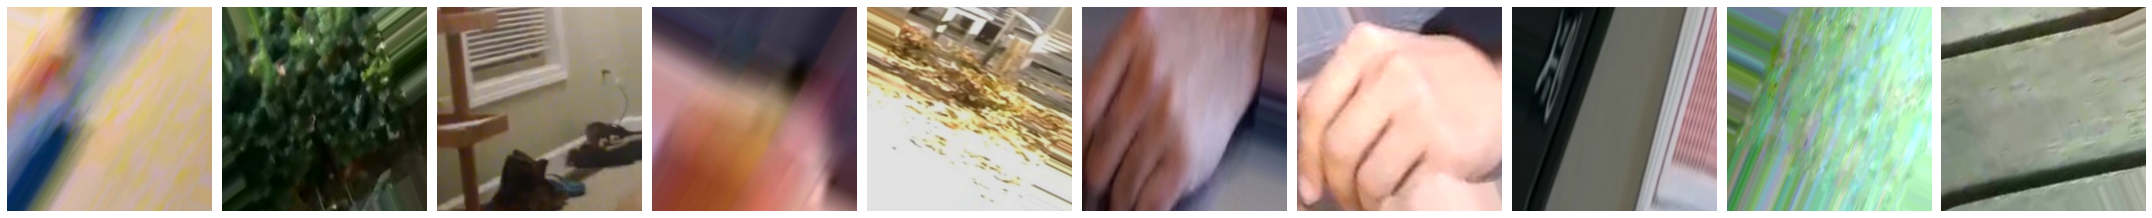

(32, 448, 448, 3)
[1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Activation, Conv2D, MaxPool2D, Dropout, Dense, Flatten, AveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
import itertools
import random
import warnings
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix

warnings.simplefilter(action='ignore', category=FutureWarning)

train_path = '/content/drive/My Drive/Colab Notebooks/dataset/train'
valid_path = '/content/drive/My Drive/Colab Notebooks/dataset/validation'
test_path = '/content/drive/My Drive/Colab Notebooks/dataset/test'

train_batches = ImageDataGenerator(rescale = 1./255, #rescale rgb values into 0-1
                                   width_shift_range = 0.1, 
                                   height_shift_range = 0.1, 
                                   rotation_range = 30, #parameters for data augmentation 
                                   zoom_range = 0.2, 
                                   shear_range = 0.2,	
                                   brightness_range=[0.8,1.2],
                                   horizontal_flip = True).flow_from_directory(directory=train_path, target_size=(448,448), color_mode = 'rgb', class_mode='binary', batch_size=32,shuffle=True)
valid_batches = ImageDataGenerator(rescale = 1./255,
                                   width_shift_range = 0.1, 
                                   height_shift_range = 0.1, 
                                   rotation_range = 30, 
                                   zoom_range = 0.2, 
                                   shear_range = 0.2,	
                                   brightness_range=[0.8,1.2],
                                   horizontal_flip = True).flow_from_directory(directory=valid_path, target_size=(448,448), color_mode = 'rgb', class_mode='binary', batch_size=32,shuffle=True)
test_batches = ImageDataGenerator(rescale = 1./255, 
                                   width_shift_range = 0.1, 
                                   height_shift_range = 0.1, 
                                   rotation_range = 30, 
                                   zoom_range = 0.2, 
                                   shear_range = 0.2,	
                                   brightness_range=[0.8,1.2],
                                   horizontal_flip = True).flow_from_directory(directory=test_path, target_size=(448,448), color_mode = 'rgb', class_mode='binary', batch_size=32,shuffle=True)


imgs, labels = next(train_batches)

print('train samples: ' + str(len(train_batches)) + '\n')
print('validation samples: ' + str(len(valid_batches)) + '\n')
print('test samples: ' + str(len(test_batches)) + '\n')
#Plotting the images...
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(30,30))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


plotImages(imgs)
print(imgs.shape)
print(labels)

Model setup and training:

In [ ]:
model = Sequential()

resnet_model = ResNet50V2(weights = None,  include_top = False,  input_tensor = Input(shape = (448,448,3)))
#model1 = ResNet50V2(weights = "imagenet",  include_top = False,  input_tensor = Input(shape = (448,448,3)))

#model2 = model1.output
#model2 = AveragePooling2D(pool_size=(7, 7))(model2)
#model2 = Flatten(name="flatten")(model2)
#model2 = Dense(128, activation="relu")(model2)
#model2 = Dropout(0.5)(model2)
#model2 = Dense(1, activation="sigmoid")(model2)
#model = Model(inputs=model1.input, outputs=model2)

model.add(resnet_model)
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'valid'))
#model2 = MaxPool2D(pool_size=(2, 2), strides=2)(model2)
#model2 = Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding = 'valid')(model2)
model.add(AveragePooling2D(pool_size=(3, 3)))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))


#model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(1280,720,3)))
#model.add(MaxPool2D(pool_size=(2, 2), strides=2))

#model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding = 'same'))
#model.add(MaxPool2D(pool_size=(2, 2), strides=2))

#model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding = 'valid'))
#model.add(MaxPool2D(pool_size=(2, 2), strides=2))

#model.add(Flatten())

#model.add(Dense(64,activation ="relu"))
#model.add(Dense(128,activation ="relu"))
#model.add(Dropout(0.2))
#model.add(Dense(128,activation ="relu"))
#model.add(Dropout(0.3))
#model.add(Dense(27,activation ="softmax"))


model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3, verbose=0, mode='auto')



#model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
#reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=0.0005)
#early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='auto')

model.summary()
history2 = model.fit(train_batches,steps_per_epoch = len(train_batches), epochs=14, callbacks=[reduce_lr, early_stop],validation_data = valid_batches, validation_steps = len(valid_batches))#, checkpoint])
#history2 = model.fit(train_batches, epochs=105, callbacks=[reduce_lr, early_stop],  validation_data = test_batches)#, checkpoint])
#imgs, labels = next(train_batches) # For getting next batch of imgs...

#imgs, labels = next(valid_batches) # For getting next batch of imgs...
#scores = model.evaluate(imgs, labels, verbose=0)
#print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')


model.save('model_resnet50.h5')

print(history2.history)

#imgs, labels = next(test_batches)

model = keras.models.load_model(r"model_resnet50.h5")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 14, 14, 2048)      23564800  
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        1179712   
                                                                 
 average_pooling2d_2 (Averag  (None, 4, 4, 64)         0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                65600     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                      

Evaluation:

TESTING PERFORMANCES ON TEST SET
PLOT GRAPH ACCURACY, TRAINING AND VALIDATION LOSS, AND SAVE IT


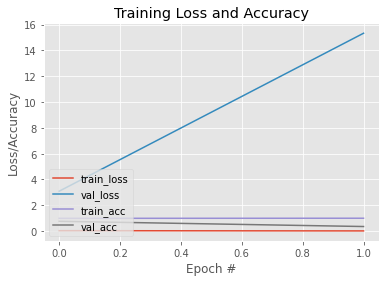

In [ ]:
# --------------------------------------------------
# TESTING PERFORMANCES ON TEST SET
# --------------------------------------------------

print("TESTING PERFORMANCES ON TEST SET")
test_batches.reset()
predictions = model.predict(test_batches, verbose = 1)

y_pred = np.rint(predictions)
y_true = test_batches.classes
print(len(y_pred))
print("CONFUSION MATRIX \n",confusion_matrix(y_true,y_pred))

# --------------------------------------------------
# PLOT ACCURACY, TRAINING AND VALIDATION LOSS
# --------------------------------------------------

print("PLOT GRAPH ACCURACY, TRAINING AND VALIDATION LOSS, AND SAVE IT")
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 10), 
        history2.history["loss"], 
        label="train_loss")
plt.plot(np.arange(0, 10), 
        history2.history["val_loss"], 
        label="val_loss")
plt.plot(np.arange(0, 10), 
        history2.history["accuracy"], 
        label="train_acc")
plt.plot(np.arange(0, 10), 
        history2.history["val_accuracy"], 
        label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluation.png')
plt.show()